This file gives an example of calculation Laughlin-like ground state in lowest Landau level with finite-system-size exact diagonalization method. 

Quasi-Bloch wavefunctions is used.

triangular lattice G1 = (G, 0), G2 = (-G/2, sqrt(3)*G/2)

Landau level n=0, Brillouin zone area = 2π/l^2 = sqrt(0.75) * G^2

Nk = # of momenta is a multiple of m, where m is odd.

filling factor 1/m

Landau level form factor

V(q) = W0 * 1/|ql| * tanh(|qD|), D/l = 5

In [1]:
k_list = [0 3 6 2 5 8 1 4 7 0 3 6 2 5 8 1 4 7 0 3 6 2 5 8 1 4 7;
          0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7 8 8 8]
Nk = 27; Gk = (9,9)
m = 3; @assert iszero(mod(Nk, m))
Ne = Nk ÷ m

9

In [2]:
#include("ExactDiagonalization.jl")
using MomentumConservedExactDiagonalization
Gl = sqrt(2π/sqrt(0.75))
D_l = 5.0
W0 = 1.0
function VFF(q1::Float64, q2::Float64)
    ql = sqrt(q1^2 + q2^2 - q1*q2) * Gl
    if ql == 0.0
        return W0 * D_l 
    end
    return W0 / ql * tanh(ql * D_l) * exp(-0.5 * ql^2)
end
function ita(g1::Int64, g2::Int64)
    if iseven(g1) && iseven(g2)
        return 1
    else
        return -1
    end
end
function ql_cross(q1_1, q1_2, q2_1, q2_2)
    return q1_1 * q2_2 - q1_2 * q2_1
end
function V_int(kf1, kf2, ki1, ki2, cf1=1, cf2=1, ci1=1, ci2=1; output=false)::ComplexF64
    ki1 = k_list[1:2, ki1]
    ki2 = k_list[1:2, ki2]
    kf1 = k_list[1:2, kf1]
    kf2 = k_list[1:2, kf2]
    q = rem.(ki1 - kf1, Gk, RoundNearest)
    G_shift1 = (ki1 - kf1 - q) .÷ Gk
    G_shift2 = (kf2 - ki2 - q) .÷ Gk

    ki1 = ki1 ./ Gk
    ki2 = ki2 ./ Gk
    kf1 = kf1 ./ Gk
    kf2 = kf2 ./ Gk

    V_total = 0.0 + 0.0im
    # N shells of reciprocal lattice vectors G
    Nshell = 2
    for g1 in -Nshell:Nshell, g2 in -Nshell:Nshell
        if abs(g1-g2) > Nshell
            continue
        end

        qq1 = q[1] / Gk[1] + g1
        qq2 = q[2] / Gk[2] + g2

        phase_angle = 0.5ql_cross(ki1[1], ki1[2], kf1[1], kf1[2])
        phase_angle += 0.5ql_cross(ki1[1]+kf1[1], ki1[2]+kf1[2], qq1, qq2)
        phase_angle += 0.5ql_cross(ki2[1], ki2[2], kf2[1], kf2[2])
        phase_angle += 0.5ql_cross(ki2[1]+kf2[1], ki2[2]+kf2[2], -qq1, -qq2)

        phase = cispi(2.0phase_angle)
        sign = ita(g1+G_shift1[1], g2+G_shift1[2]) * ita(g1+G_shift2[1], g2+G_shift2[2])

        V_total += sign * phase * VFF(qq1, qq2)
    end

    return V_total
end
para = EDPara(k_list=k_list, Gk=Gk, V_int = V_int);

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Warning: Replacing docs for `MomentumConservedExactDiagonalization.ED_Hmlt_Matrix :: Union{Tuple{bits}, Tuple{Array{MomentumConservedExactDiagonalization.MBS64{bits}, 1}, Vector{MomentumConservedExactDiagonalization.Scattering{1}}, Vector{MomentumConservedExactDiagonalization.Scattering{2}}}} where bits` in module `MomentumConservedExactDiagonalization`
└ @ Base.Docs docs\Docs.jl:243
┌ Warning: Replacing docs for `MomentumConservedExactDiagonalization.create_state_mapping :: Union{Tuple{Array{MomentumConservedExactDiagonalization.MBS64{bits}, 1}}, Tuple{bits}} where bits` in module `MomentumConservedExactDiagonalization`
└ @ Base.Docs docs\Docs.jl:243
┌ Warning: Replacing docs for `MomentumConservedExactDiagonalization.ED_Hmlt_Matrix_threaded :: Union{Tuple{bits}, Tuple{Array{MomentumConservedExactDiagonalization.MBS64{bits}, 1}, Vector{MomentumConservedE

LoadError: LoadError: UndefVarError: `bits` not defined in `MomentumConservedExactDiagonalization`
Suggestion: check for spelling errors or missing imports.
in expression starting at c:\Users\zoubo\PhysicsWorking\MomentumConservedExactDiagonalization.jl\src\MomentumConservedExactDiagonalization.jl:1

In [4]:
blocks, block_k1, block_k2, k0number = 
    ED_momentum_block_division(para, ED_mbslist(para, (Ne,)));
length.(blocks)

27-element Vector{Int64}:
 173613
 173583
 173583
 173583
 173583
 173583
 173583
 173583
 173583
 173583
      ⋮
 173583
 173610
 173583
 173583
 173583
 173583
 173583
 173583
 173583

In [5]:
scat_list1 = ED_sortedScatteringList_onebody(para);
scat_list2 = ED_sortedScatteringList_twobody(para);

In [7]:
energies = Vector{Vector{Float64}}(undef, length(blocks))
Neigen = 10
for i in eachindex(blocks)
    println("Processing block #$i with size $(length(blocks[i])), momentum $(block_k1[i]), $(block_k2[i])")
    @time H = ED_Hmlt_Matrix(blocks[i], scat_list1, scat_list2)
    @time energies[i] = EDsolve(H, Neigen)[1]
end

Processing block #1 with size 173613, momentum 0, 0
 67.515312 seconds (1.04 G allocations: 19.075 GiB, 2.09% gc time)
 35.036117 seconds (15.74 k allocations: 4.097 GiB, 1.42% gc time, 0.02% compilation time)
Processing block #2 with size 173583, momentum 0, 3
 72.659755 seconds (1.04 G allocations: 19.072 GiB, 2.40% gc time)
 28.106604 seconds (9.95 k allocations: 3.164 GiB, 1.60% gc time)
Processing block #3 with size 173583, momentum 0, 6
 70.500118 seconds (1.04 G allocations: 19.072 GiB, 2.36% gc time)
 27.686138 seconds (9.99 k allocations: 3.164 GiB, 1.54% gc time)
Processing block #4 with size 173583, momentum 1, 2
 69.994278 seconds (1.04 G allocations: 19.072 GiB, 2.34% gc time)
 40.087432 seconds (15.04 k allocations: 4.743 GiB, 1.56% gc time)
Processing block #5 with size 173583, momentum 1, 5
 70.732518 seconds (1.04 G allocations: 19.072 GiB, 2.34% gc time)
 32.512834 seconds (11.51 k allocations: 3.641 GiB, 1.56% gc time)
Processing block #6 with size 173583, momentum 1

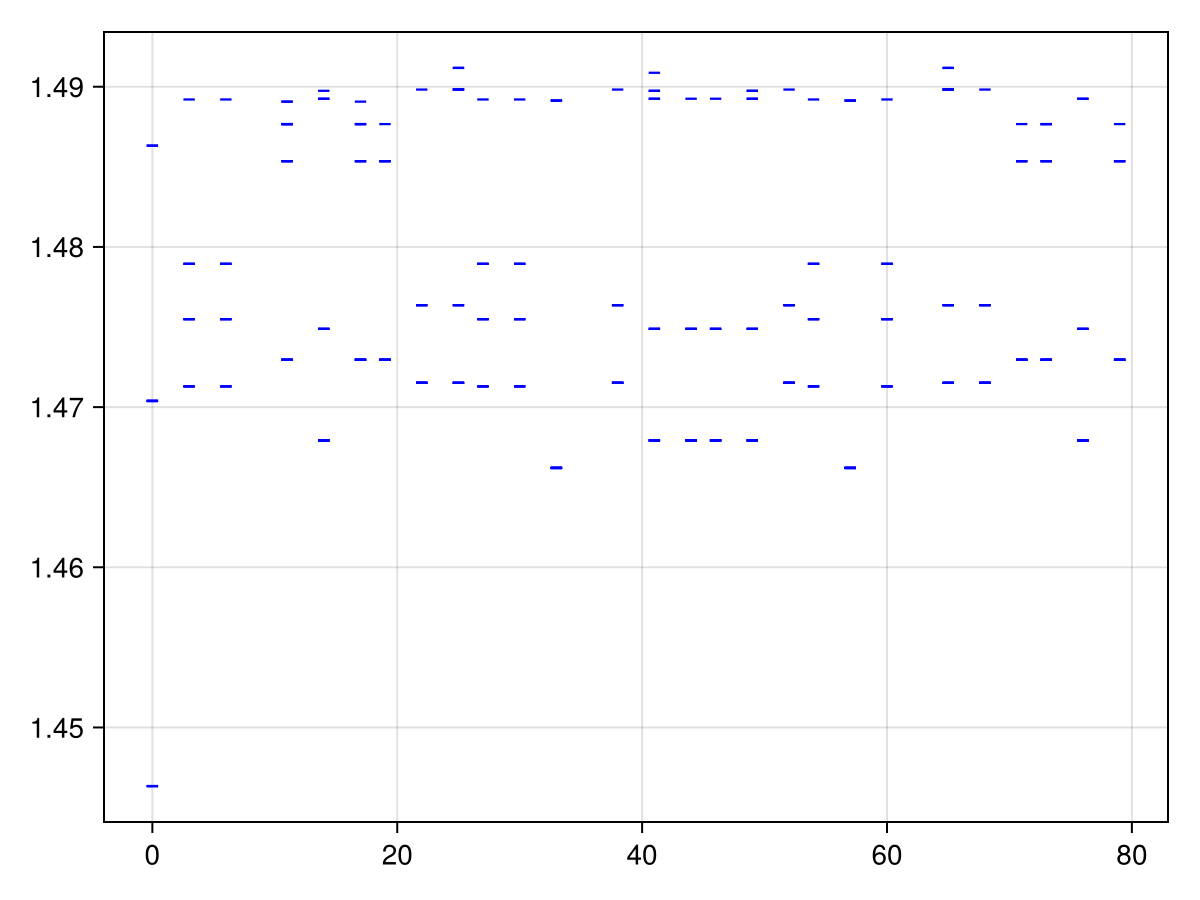

CairoMakie.Screen{IMAGE}


In [8]:
using CairoMakie
CairoMakie.activate!()
begin
    fig = Figure();
    ax = Axis(fig[1, 1])
    for i in 1:length(blocks)
        for e in energies[i]
            scatter!(ax, Gk[2]*block_k1[i]+block_k2[i], e, color = :blue, marker=:hline)
        end
    end
    fig
end
display(fig)

In [9]:
energies[1]

10-element Vector{Float64}:
 1.4463412900387416
 1.446341290038743
 1.446341290038743
 1.4703844009654894
 1.4703844009654907
 1.4703844009654934
 1.4703844009654952
 1.4703844009654965
 1.4863227429747377
 1.4863227429747403